In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import datetime
import json
import tensorflow as tf
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.optimizers.experimental import AdamW
from tensorflow.keras.losses import SparseCategoricalCrossentropy, MeanSquaredError
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tqdm.keras import TqdmCallback

#sns.set_theme()

try: # are we in Colab?
    import google.colab
    COMPUTE_ENV = 'colab'
    print('Running in Colab.')
    google.colab.drive.mount('/content/gdrive')
    OUTPUT_DIR = "/content/gdrive/My Drive/output"
    !git clone https://github.com/FriedChips/dl_basics.git
    !pip install einops
    sys.path.insert(0,'/content/dl_basics')
except: # if not...
    if "kaggle" in os.environ["PWD"]: # are we in Kaggle?
        COMPUTE_ENV = 'kaggle'
        print('Running in Kaggle.')
        !git clone https://github.com/FriedChips/dl_basics.git
        !pip install einops
        sys.path.insert(0,'../working/dl_basics')    
        OUTPUT_DIR = "./"
    else: # we're local
        COMPUTE_ENV = os.uname()[1]
        print(f"Running locally on {COMPUTE_ENV}.")
        sys.path.insert(0,'./../')
        OUTPUT_DIR = "../output/"

for gpu in tf.config.list_physical_devices("GPU"):
    print(f"Found GPU: {tf.config.experimental.get_device_details(gpu)['device_name']}.")

2023-04-26 07:53:23.011476: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Running locally on beta.


In [2]:
#import models
import utils
from einops import rearrange, einsum
from scipy.special import erf

In [3]:
def plot_matrix(m, ax, scale=1.0, transpose=False):
    m = np.copy(m)
    mmax = np.max(np.abs(m)) / scale
    if transpose:
        m = m.T
    ax.imshow(m, cmap="bwr", vmin=-mmax, vmax=mmax, interpolation="nearest")
    ax.grid(False)

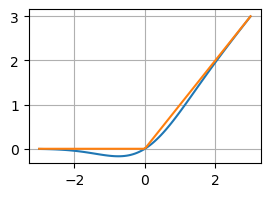

In [4]:
from scipy.special import erf

def gelu(x):
    return x / 2 * (1 + erf(x / np.sqrt(2)))

def relu(x):
    return np.maximum(x, 0)

fig, ax = plt.subplots(1,1,figsize=(3,2))
x_range = np.linspace(-3,3,100)
ax.plot(x_range, gelu(x_range));
ax.plot(x_range, relu(x_range));
ax.grid(True)

In [5]:
def plot_usv(i):
    fig, axs = plt.subplots(1, 4, figsize=(20,5))
    plot_matrix(w[i][:], axs[0])
    plot_matrix(s[i][:], axs[1])
    plot_matrix(u[i][:], axs[2])
    plot_matrix(vt[i][:], axs[3])

In [7]:
run = utils.TrainingRun()
#P, model = run.load_state("/cloud/markus/gdrive/output/mnist_conv230424-230424-095825/")
P, model = run.load_state("/cloud/markus/gdrive/output/mnist_conv230424-230424-153013/")
#P, model = run.load_state("/cloud/markus/gdrive/output/mnist_conv230424-230424-155508/")
#P, model = run.load_state("/cloud/markus/gdrive/output/conv230424-230425-120008/")


2023-04-26 07:53:56.162361: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-26 07:53:56.162971: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [8]:
P, run.current_epoch

({'training_data': 'mnist50-10',
  'model_name': 'mnist_conv230424',
  'model_build_params': {'filters': [16, 8, 10],
   'kernel_sizes': [5, 5, 4],
   'strides': [2, 2, 1],
   'activations': ['relu', 'relu', 'linear'],
   'use_bias': False,
   'regularizer': None},
  'random_seed': 42,
  'loss': 'SparseCategoricalCrossentropy(from_logits=True)',
  'optimizer': 'AdamW(1e-3, weight_decay=1)',
  'metrics': ['accuracy'],
  'run_dir': 'mnist_conv230424-230424-153013'},
 2048)

Shapes : (60000, 28, 28, 1) (60000,) (10000, 28, 28, 1) (10000,)


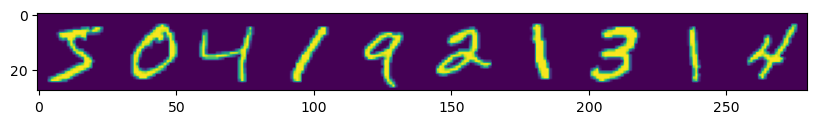

In [9]:
if P["training_data"] == "mnist":
    dataset = tf.keras.datasets.mnist
elif P["training_data"] == "fashion_mnist":
    dataset = tf.keras.datasets.fashion_mnist
elif P["training_data"] == "cifar10":
    dataset = tf.keras.datasets.cifar10
else:
    #raise Exception("Unknown dataset.")
    dataset = tf.keras.datasets.mnist

(x_train, y_train), (x_val, y_val) = dataset.load_data()

x_train = x_train.astype(np.float32) / 255.0
x_val   = x_val.astype(np.float32)   / 255.0

if len(x_train.shape) == 3:
    x_train = np.expand_dims(x_train, -1)
    x_val   = np.expand_dims(x_val,   -1)

print("Shapes :", x_train.shape, y_train.shape, x_val.shape, y_val.shape)

fig, ax = plt.subplots(1, 1, figsize=(10,1))
plt.imshow(rearrange(x_train[:10], "b h w c -> h (b w) c"));

In [10]:
w = model.get_weights()
print([ wi.shape for wi in w ])

[(5, 5, 1, 16), (5, 5, 16, 8), (4, 4, 8, 10)]


In [18]:
from scipy.linalg import svd, diagsvd

def conv2d_weights_svd(w, verbose=False):

    w_shape = w.shape
    assert len(w_shape) == 4

    w = rearrange(w, "k_x k_y c_in c_out -> (k_x k_y c_in) c_out")
    u, s_array, vt = svd(w)
    s = diagsvd(s_array, *w.shape)

    if verbose:
        print(f"u.shape = {u.shape}. s.shape = {s.shape}. vt.shape = {vt.shape}.")

    return u, s, vt

In [20]:
u, s, vt = [], [], []

for i, wi in enumerate(w):
    print(f"Layer {i} :")
    ui, si, vti = conv2d_weights_svd(wi, verbose=True)
    u.append(ui)
    s.append(si)
    vt.append(vti)

Layer 0 :
u.shape = (25, 25). s.shape = (25, 16). vt.shape = (16, 16).
Layer 1 :
u.shape = (400, 400). s.shape = (400, 8). vt.shape = (8, 8).
Layer 2 :
u.shape = (128, 128). s.shape = (128, 10). vt.shape = (10, 10).


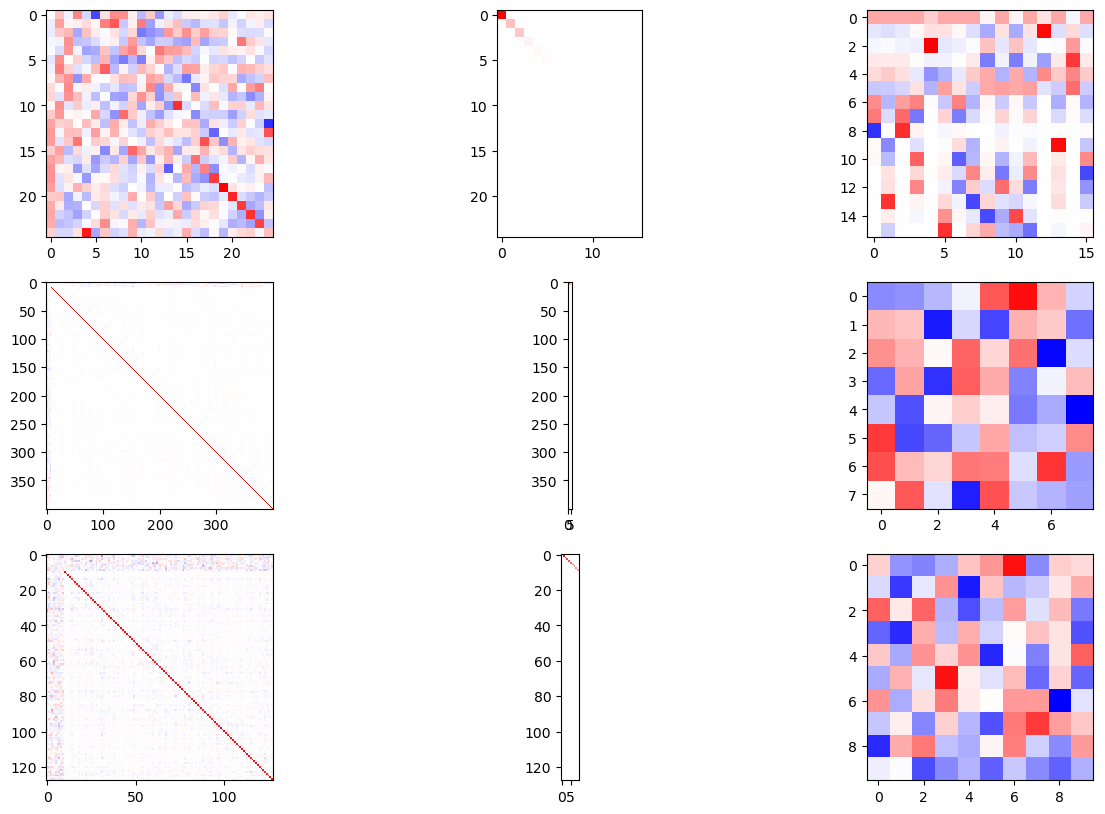

In [36]:
fig, axs = plt.subplots(3, 3, figsize=(15,10))
for i in range(3):
    plot_matrix(u[i],  axs[i,0])
    plot_matrix(s[i],  axs[i,1])
    plot_matrix(vt[i], axs[i,2])

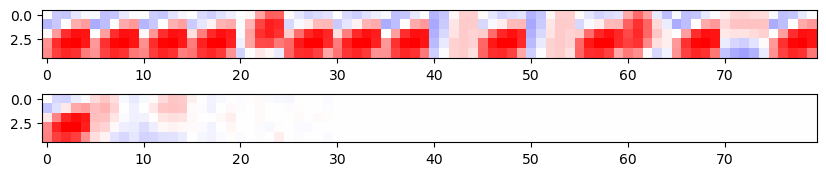

In [29]:
fig, axs = plt.subplots(2, 1, figsize=(10,2))

m = rearrange(w[0], "h w nh nw -> (nh h) (nw w)")
plot_matrix(m, axs[0])

m = (u[0] @ s[0]).reshape(*w[0].shape)
m = rearrange(m, "h w nh nw -> (nh h) (nw w)")
plot_matrix(m, axs[1], scale=1)


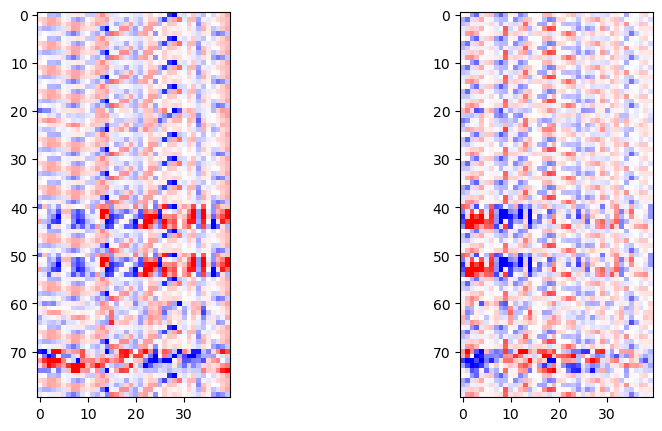

In [32]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))

m = rearrange(w[1], "h w nh nw -> (nh h) (nw w)")
plot_matrix(m, axs[0], scale=2)

m = (u[1] @ s[1]).reshape(*w[1].shape)
m = rearrange(m, "h w nh nw -> (nh h) (nw w)")
plot_matrix(m, axs[1], scale=2)


(1, 28, 28, 1)


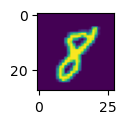

In [37]:
inp = x_train[17]

fig, ax = plt.subplots(1,1, figsize=(1,1))
#plot_matrix(inp, ax)
ax.imshow(inp)

inp = rearrange(inp, "w h c -> 1 w h c")
print(inp.shape)


In [38]:
extractor = tf.keras.Model(inputs=model.inputs, outputs=[layer.output for layer in model.layers])
ext_out = extractor.predict(inp)
print([ o.shape for o in ext_out ])

1/1 [==============================] - 0s 145ms/step
[(1, 28, 28, 1), (1, 12, 12, 16), (1, 12, 12, 16), (1, 4, 4, 8), (1, 4, 4, 8), (1, 1, 1, 10), (1, 10)]


In [42]:
def transform_input(inp, kernel_size, strides):

    kernel_corners = np.arange(0, inp.shape[0] - kernel_size + 1, strides)
    dim_xy_out = len(kernel_corners)
    print(kernel_corners, dim_xy_out)

    inp_transf = [ [ inp[y:y+kernel_size, x:x+kernel_size, :] for x in kernel_corners ] for y in kernel_corners ]

    inp_transf = np.array(inp_transf).reshape(dim_xy_out, dim_xy_out, -1)

    return inp_transf

transform_input(inp[0], 5, 2).shape

[ 0  2  4  6  8 10 12 14 16 18 20 22] 12


(12, 12, 25)

In [44]:
(transform_input(inp[0], 5, 2) @ u[0] @ s[0] @ vt[0])

[ 0  2  4  6  8 10 12 14 16 18 20 22] 12


(12, 12, 16)

[ 0  2  4  6  8 10 12 14 16 18 20 22] 12
[ 0  2  4  6  8 10 12 14 16 18 20 22] 12


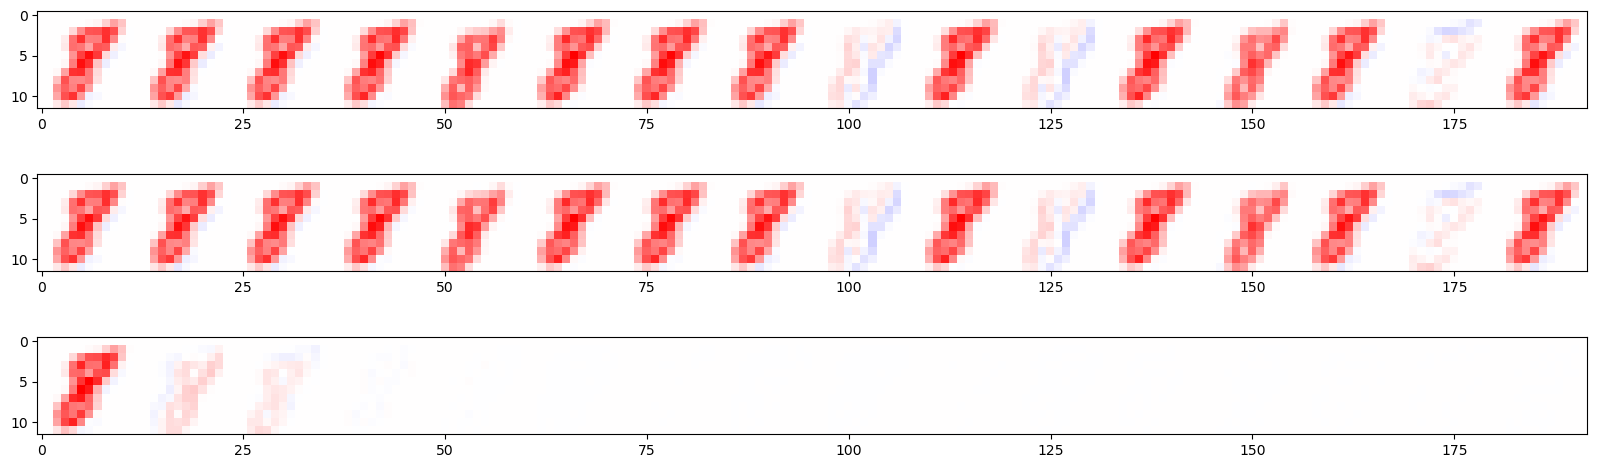

In [54]:
fig, axs = plt.subplots(3, 1, figsize=(20,6))

m = rearrange(ext_out[1][0], "h w c -> h (c w)")
plot_matrix(m, axs[0], scale=1)

m1 = transform_input(inp[0], 5, 2) @ u[0] @ s[0] @ vt[0]
m = rearrange(m1, "h w c -> h (c w)")
plot_matrix(m, axs[1], scale=1)

m1 = transform_input(inp[0], 5, 2) @ u[0] @ s[0]
m = rearrange(m1, "h w c -> h (c w)")
plot_matrix(m, axs[2], scale=1)


[0 2 4 6] 4
[0 2 4 6] 4


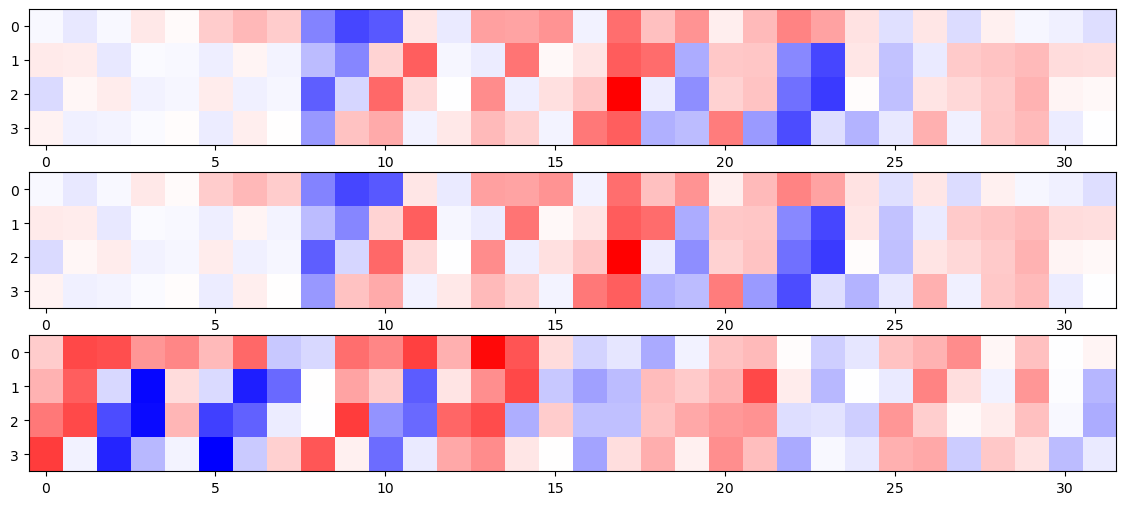

In [59]:
fig, axs = plt.subplots(3, 1, figsize=(20,6))

m = rearrange(ext_out[3][0], "h w c -> h (c w)")
plot_matrix(m, axs[0], scale=1)

m1 = transform_input(ext_out[2][0], 5, 2) @ u[1] @ s[1] @ vt[1]
m = rearrange(m1, "h w c -> h (c w)")
plot_matrix(m, axs[1], scale=1)

m1 = transform_input(ext_out[2][0], 5, 2) @ u[1] @ s[1]
m = rearrange(m1, "h w c -> h (c w)")
plot_matrix(m, axs[2], scale=1)